In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import rpy2
from sklearn.decomposition import PCA
sys.path.append('..')

In [3]:
WIN = 'D:/'
MAC = '/Volumes/Transcend2/17_20_PhD/19_20_PhD_Metabolomics/'

osp = MAC

In [4]:
MZMINE_COMMAND = osp+'git/MZmine-2.40.1/startMZmine_MacOSX.command'

In [5]:
MNET_PATH = osp+'git/molnet/code/'

## 1. Divide samples into control or condition

In [60]:
output_dir = osp+'pymz/mzmine/peak_picked_files/mal/'

In [68]:
dataset_name = 'Malaria'

In [69]:
aligned_file = output_dir + 'pp_aligned.csv'

In [70]:
all_df = pd.read_csv(aligned_file, index_col=0)
feature_description = all_df.iloc[:,:2]
all_samples = all_df.iloc[:,2:-1]
all_samples.columns = [x.split(" ")[0] for x in list(all_samples.columns)]

## 2. Create samples description dataframe

In [71]:
condition = []
dataset = []
for name in np.array(all_samples.columns):
    value = name.split('.')[0].split('_')[0][0]
    value2 = name.split('.')[0].split('_')[0][0]
    
    if (value == 'C' and len(name.split('.')[0].split('_')) == 2 and name.split('.')[0].split('_')[1] == '2'):
        condition.append('control')
        dataset.append('VL')
    elif  (value == 'C'):   
        condition.append('control')
        dataset.append('Zika')
    elif (value == 'Z'):
        condition.append('infected')
        dataset.append('Zika')
    elif (value[0] == 'V'):
        condition.append('infected')
        dataset.append('VL')
    elif (name.split('.')[0][0] == 'A' or name.split('.')[0][0] == 'B'):
        dataset.append('HAT')
        if name.split('.')[0][4] == 'P':
            condition.append('infected')
        elif name.split('.')[0][4] == 'C':
            condition.append('control')   
    elif (value == 'K' and int(name.split('.')[0].split('_')[1])%3 == 1 ):
        condition.append('control')
        dataset.append('Malaria')
    else:
        condition.append('infected')
        dataset.append('Malaria')
        
sample_description = pd.DataFrame(data=[list(all_samples.columns),condition,dataset] )
sample_description = sample_description.transpose()
sample_description.columns = ['Sample Name', 'Condition', 'Dataset']

In [72]:
sample_description = pd.read_csv(osp+'sample_description.csv')
sample_description = sample_description[sample_description['Dataset'] == dataset_name]

In [73]:
sample_description["ConditionDataset"] = sample_description["Condition"]+sample_description["Dataset"]

In [74]:
sample_description

,Sample Name,Condition,Dataset,ConditionDataset
0,KM_10.mzXML,control,Malaria,controlMalaria
1,KM_9.mzXML,infected,Malaria,infectedMalaria
2,KM_3.mzXML,infected,Malaria,infectedMalaria
3,KM_4.mzXML,control,Malaria,controlMalaria
4,KM_1.mzXML,control,Malaria,controlMalaria
5,KM_16.mzXML,control,Malaria,controlMalaria
6,KM_13.mzXML,control,Malaria,controlMalaria
7,KM_12.mzXML,infected,Malaria,infectedMalaria
8,KM_19.mzXML,control,Malaria,controlMalaria
9,KM_18.mzXML,infected,Malaria,infectedMalaria


In [ ]:
#Save the sample description to a csv file.
#sample_description = pd.read_csv('/Users/anamaria/Desktop/mzmine/221119/sample_description.csv', sep=',', index_col = 0)

## 3. Preprocess intensities dataframe

#### 1. Log the sample intensities in order to prepare it for limma analysis.

In [75]:
all_samples_log = np.log2(all_samples+1)

In [76]:
print("The number of samples is: {}".format(len(all_samples_log)))

The number of samples is: 12868


In [77]:
all_samples_log = all_samples_log[list(sample_description['Sample Name'])]

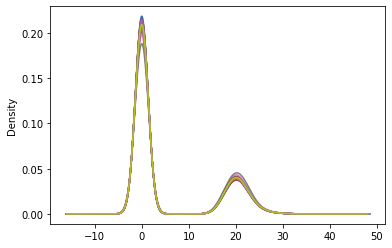

In [172]:
all_samples_log.plot.density(legend = False)

#### 2. Rearrange the dataframe based on condition.

In [78]:
alldataset = all_samples_log.transpose()[np.array(sample_description['Dataset'] == dataset_name)].transpose()
con = alldataset.transpose()[np.array(sample_description[sample_description["Dataset"] == 
                                                         dataset_name]['Condition'] =="control")].transpose()
inf = alldataset.transpose()[np.array(sample_description[sample_description["Dataset"] == 
                                                         dataset_name]['Condition'] =="infected")].transpose()

pdList = [con, inf]  
all_samples_log_rearanged = pd.concat(pdList, axis = 1)

#### 3. Plot heatmap of the logged intensities.

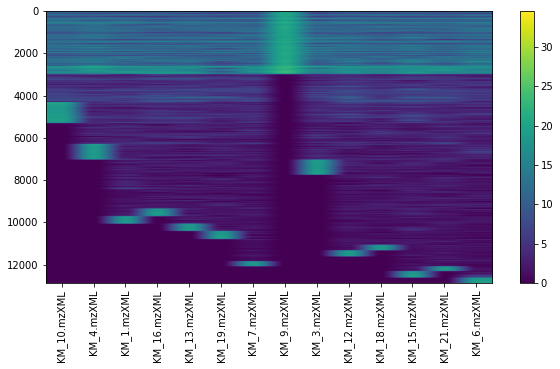

In [79]:
plt.figure(figsize=(10,5))
plt.imshow(all_samples_log_rearanged,aspect='auto')
plt.xticks(list(range(0,len(all_samples_log_rearanged.columns))), all_samples_log_rearanged.columns, rotation = 90)
plt.colorbar()
plt.show()


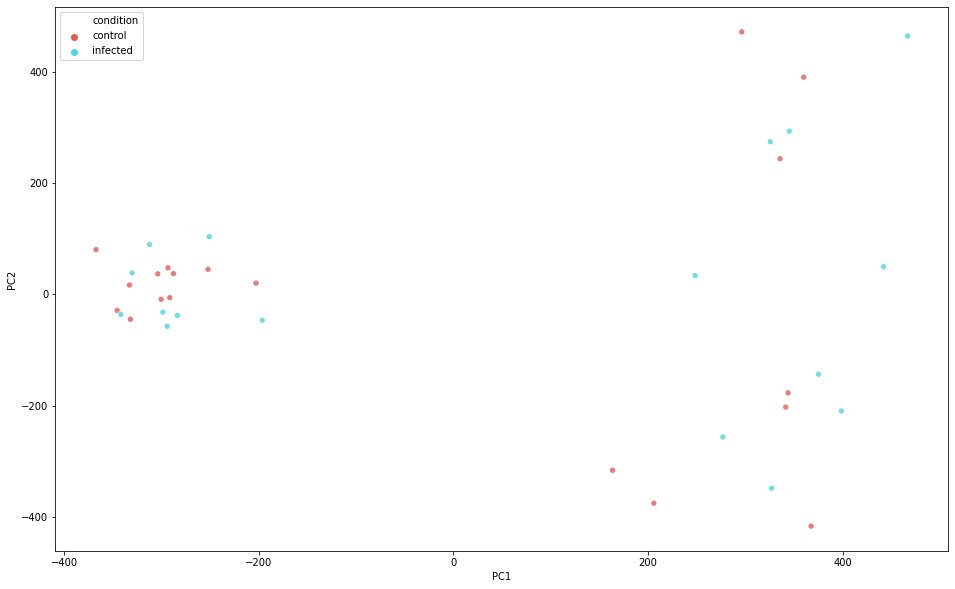

In [44]:
pca_samples = PCA(n_components=3)

principalComponents = pca_samples.fit_transform(all_samples_log_rearanged.transpose())
principalComponents_df = pd.DataFrame(data = principalComponents, columns= ['PC1','PC2', 'PC3'])
principalComponents_df['condition'] = list(sample_description['Condition'])
principalComponents_df['dataset'] = list(sample_description['Dataset'])

plt.figure(figsize=(16,10))
sns.scatterplot(x="PC1", y="PC2",hue="condition",
    palette=sns.color_palette("hls", 2),
    data=principalComponents_df,
    legend="full",
    alpha=0.8
)

#### 4. Filter data, so that 50% of the peaks in each dataset are not 0s.


Skip this step for individual datasets.

In [80]:
def get_ids_for_x_percent(x,dataframe):
    idlist = []
    for rowid,row in dataframe.iterrows():
        total_zero = 0
        for i in range(len(row)):
            if row[i] == 0.0:
                total_zero += 1
        percentage = total_zero*100/len(row)
        if percentage <= x:
            idlist.append(rowid)
    return np.array(idlist)

In [81]:
iddataset = get_ids_for_x_percent(50, all_samples_log_rearanged[alldataset.columns])
inters = set(iddataset)
print(len(inters))
all_samples_log_filtered_50 = all_samples_log.loc[inters]
#all_samples_log_filtered_50.plot.density(legend=False)

2152


#### 5. Impute missing values using KNN

Skip this step for individual datasets analysis.

In [123]:
from fancyimpute import KNN
def impute_knn(con, dataset):
    con_filt = dataset[con.columns]
    con_filt.replace(0, np.nan, inplace = True)
    con_filled_knn = KNN(k=3).fit_transform(con_filt)
    df = pd.DataFrame(con_filled_knn, columns=con_filt.columns, index = con_filt.index)
    return df

In [174]:
all_samples_log_filtered_na = all_samples_log.copy()
all_samples_log_filtered_na.replace(0, np.nan, inplace = True)

con_filled = impute_knn(con, all_samples_log_filtered_na)
inf_filled = impute_knn(inf, all_samples_log_filtered_na)


/Users/anamaria/.pyenv/versions/3.8.1/lib/python3.8/site-packages/pandas/core/frame.py:4166: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().replace(


Imputing row 1/12393 with 0 missing, elapsed time: 33.448
Imputing row 101/12393 with 0 missing, elapsed time: 33.483
Imputing row 201/12393 with 8 missing, elapsed time: 33.506
Imputing row 301/12393 with 0 missing, elapsed time: 33.527
Imputing row 401/12393 with 0 missing, elapsed time: 33.550
Imputing row 501/12393 with 4 missing, elapsed time: 33.565
Imputing row 601/12393 with 0 missing, elapsed time: 33.589
Imputing row 701/12393 with 0 missing, elapsed time: 33.606
Imputing row 801/12393 with 0 missing, elapsed time: 33.631
Imputing row 901/12393 with 9 missing, elapsed time: 33.648
Imputing row 1001/12393 with 9 missing, elapsed time: 33.681
Imputing row 1101/12393 with 0 missing, elapsed time: 33.699
Imputing row 1201/12393 with 8 missing, elapsed time: 33.717
Imputing row 1301/12393 with 9 missing, elapsed time: 33.750
Imputing row 1401/12393 with 0 missing, elapsed time: 33.771
Imputing row 1501/12393 with 1 missing, elapsed time: 33.791
Imputing row 1601/12393 with 8 missi

/Users/anamaria/.pyenv/versions/3.8.1/lib/python3.8/site-packages/pandas/core/frame.py:4166: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().replace(


Imputing row 1/12393 with 0 missing, elapsed time: 32.587
Imputing row 101/12393 with 0 missing, elapsed time: 32.615
Imputing row 201/12393 with 9 missing, elapsed time: 32.649
Imputing row 301/12393 with 0 missing, elapsed time: 32.670
Imputing row 401/12393 with 0 missing, elapsed time: 32.695
Imputing row 501/12393 with 5 missing, elapsed time: 32.718
Imputing row 601/12393 with 0 missing, elapsed time: 32.756
Imputing row 701/12393 with 0 missing, elapsed time: 32.779
Imputing row 801/12393 with 1 missing, elapsed time: 32.808
Imputing row 901/12393 with 7 missing, elapsed time: 32.832
Imputing row 1001/12393 with 8 missing, elapsed time: 32.861
Imputing row 1101/12393 with 0 missing, elapsed time: 32.886
Imputing row 1201/12393 with 9 missing, elapsed time: 32.910
Imputing row 1301/12393 with 9 missing, elapsed time: 32.943
Imputing row 1401/12393 with 0 missing, elapsed time: 32.972
Imputing row 1501/12393 with 2 missing, elapsed time: 32.999
Imputing row 1601/12393 with 9 missi

In [175]:
pdList = [con_filled, inf_filled]  
all_samples_log_filled = pd.concat(pdList, axis = 1)
all_samples_log_filled = all_samples_log_filled[all_samples_log.columns]

## 4. Limma analysis in R

In [82]:
filtered_samples_log = all_samples_log_filtered_50[list(sample_description['Sample Name'])]

In [83]:
all_samples_log_file = output_dir+'filtered_samples_log.csv'
sample_description_file = output_dir+'sample_description.csv'

filtered_samples_log.to_csv(all_samples_log_file, header=True, index=True, sep=',', mode='w')
sample_description.to_csv(sample_description_file, header=True, index=None, sep=',', mode='w')

file_to_be_analysed = all_samples_log_file

In [84]:
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [85]:
%%R

library(limma)
library(Biobase)

In [86]:
%%R -i file_to_be_analysed -i sample_description_file -i dataset_name

options(error=recover)

eset = readExpressionSet(file_to_be_analysed, sample_description_file, 
                         exprsArgs=list(sep=",", header=TRUE,quote="",row.names=1),
                         phenoDataArgs=list(sep=",", header=TRUE,quote=""))

edata = exprs(eset)
pheno = pData(eset)

#creating the levels for the Condition and Dataset in pData
levels(pheno$Condition) = c('control','infected')
levels(pheno$Dataset)  = c(dataset_name)
pData(eset) = pheno



In [87]:
limma_table_file = output_dir + 'limma_independent_toptable_filtered.csv'

In [88]:
%%R -i limma_table_file

eset.dataset = factor(as.character(pData(eset)$Dataset))
eset.condition = factor(as.character(pData(eset)$Condition))

eset.design = model.matrix(~ 0 + eset.condition)
eset.fit = lmFit(eset, eset.design)
head(coef(eset.fit))

#define the contrasts you want to make, estimate the coefficients 
#and std errs for these contrasts, eBayes moderation of std errs.

contr = makeContrasts(eset.conditioninfected - eset.conditioncontrol, levels=colnames(coef(eset.fit)))
eset.fit = contrasts.fit(eset.fit, contr)
eset.fit = eBayes(eset.fit)

#Extract results per metabolite
top.table = topTable(eset.fit, sort.by="p", n=Inf)
head(top.table)
write.csv(top.table, file = limma_table_file, sep = ",", quote = FALSE) #should be \t sep for mummichog to work

In [89]:
limma_table = pd.read_csv(limma_table_file, sep=',')
limma_table.index = limma_table[limma_table.columns[0]]
del limma_table[(limma_table.columns[0])]

In [95]:
print("The number of significantly different metabolites is:",len(limma_table[limma_table['adj.P.Val'] < 0.05]))

The number of significantly different metabolites is: 5


In [93]:
#Prepare .csv for mummichog
data = feature_description.loc[limma_table.index]
data['adj-p'] = limma_table['adj.P.Val']
data['t-val'] = limma_table['t']
#data['logFC'] = limma_table['logFC']
data['custom_id'] = list(data.index)


In [92]:
data.to_csv(output_dir+'limma_independent_toptable_features_filtered.csv', header=True, index=True, sep='\t', mode='w')


In [94]:
data.to_csv(output_dir+'limma_independent_toptable_features_mm.csv', header=True, index=None, sep='\t', mode='w')
#needs to be with \t instead of , , for mummichog to work

## 5. Preparing file for mummichog and further analysis

In [54]:
import os
os.system('mummichog -f'+'/Users/anamaria/Desktop/mzmine/zik_topfeatures.txt'+' -m positive -c 0.05 -u 3 -o mm')

256

In [73]:
compounds = pd.read_csv('1588152677.696043.mm/tables/ListOfEmpiricalCompounds.tsv', sep='\t')
featureoutput = pd.read_csv('1588152677.696043.mm/tables/userInputData.txt', sep='\t')

In [74]:
matching_ids = {}
for _,row in featureoutput.iterrows():
    key = row['massfeature_rows']
    value = row['CompoundID_from_user']
    matching_ids[key] = value

In [75]:
compounds_dict = {}
for _,row in compounds.iterrows():
    ids = row['massfeature_rows']
    ions = row['str_row_ion']
    compoundlist = row['compound_names']
    
    ids_list = ids.split(';')
    ions_list = ions.split(';')
    for i in range(len(ids_list)):
        compounds_dict[matching_ids[ids_list[i]]] = []
        compounds_dict[matching_ids[ids_list[i]]].append(ions_list[i].split('_')[1])
        compounds_dict[matching_ids[ids_list[i]]].append(compoundlist)
        

In [76]:
for row_id,row in data.iterrows():
    if row_id in list(compounds_dict.keys()):
        
        data.at[row_id,'compound_names'] = compounds_dict[row_id][-1]
    else:
         data.at[row_id,'compound_names'] = 'NaN'
    

In [78]:
data.to_csv(r'/Users/anamaria/Desktop/mzmine/hat_mm_annotated.txt', header=True, index=None, sep='\t', mode='w')